In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [226]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['alt_student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='Entries').sum(axis=1))).fillna(0)

# Teacher activity
df['teacher_activity'] =  np.log((df.filter(regex='_cor_tch').sum(axis=1)/df['Entries|2016_Physics']).fillna(0))

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Take schools that had low performance 
#df = df[(df.filter(like='exam_score|2013')<0.7).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# Create log student activity
df['log_student_activity'] = np.log(df['student_activity'] + 1)

df.head(5)
print(df.shape)

(899, 58)


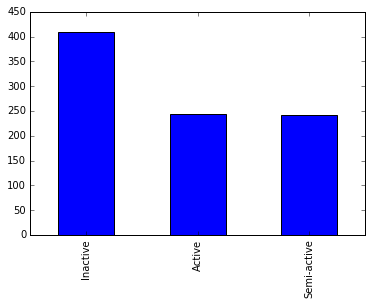

In [224]:
# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 10,1000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['student_activity']].quantile(0.95)
df_out = df[(df[q.keys()] < q).all(axis=1)]


# Plot a histogram
df['categories'].value_counts().plot(kind='bar')



In [177]:
# Doing a sensitivity analysis on the p-value
from sklearn.feature_selection import f_classif

# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories

# ------------------------------------------------------
# Iterating over cut off values
# ------------------------------------------------------

group_names = ['Inactive','Semi-active','Active']
bins = [-0.1, 0, 1,10000]

cut_off_array = list(range(1,200))
store= [];

for item in cut_off_array:

    # Updating bins
    bins[2] = item
        
    # Binning the groups
    df_test = df
    df_test['categories'] = bin_groups(df_test,'student_activity',bins,group_names)
    num_active = df_test['categories'].value_counts().loc['Active']
    df_test = df_test[df_test['categories']!= 'Semi-active']

    # Performing an ANOVA test
    X = df_test.filter(regex='exam_improv')
    y = [1 if item == 'Active' else 0 for item in df_test['categories']]
    F, pval = f_classif(X, y)
        
    # Determining difference in means between active and inactive groups
    mu_active_inactive = df_test[df_test['categories']=='Active'].filter(regex='exam_improv').mean() - df_test[df_test['categories']=='Inactive'].filter(regex='exam_improv').mean()
    #print(mu_active_inactive['exam_improv_2013-2016_Physics'])
    
    # Storing the array as a Dataframe
    df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval,'Cut off':np.ones(len(X.keys()))*item, 'Num active':num_active, 'Active - Inactive':mu_active_inactive[X.keys()]})
    store.append(df_score)

df_score = pd.concat(store)
df_score[df_score['Key'] == 'exam_improv_2013-2016_Biology'].tail(5)

# Printing the minimum p values for each subject
print('Smallest p value for each feature')
df_score.groupby('Key').min()['p values']

Smallest p value for each feature


Key
exam_improv_2013-2014_Biology        0.492755
exam_improv_2013-2014_Chemistry      0.194667
exam_improv_2013-2014_Mathematics    0.408951
exam_improv_2013-2014_Physics        0.121584
exam_improv_2013-2016_Biology        0.207456
exam_improv_2013-2016_Chemistry      0.048244
exam_improv_2013-2016_Mathematics    0.032984
exam_improv_2013-2016_Physics        0.018710
Name: p values, dtype: float64

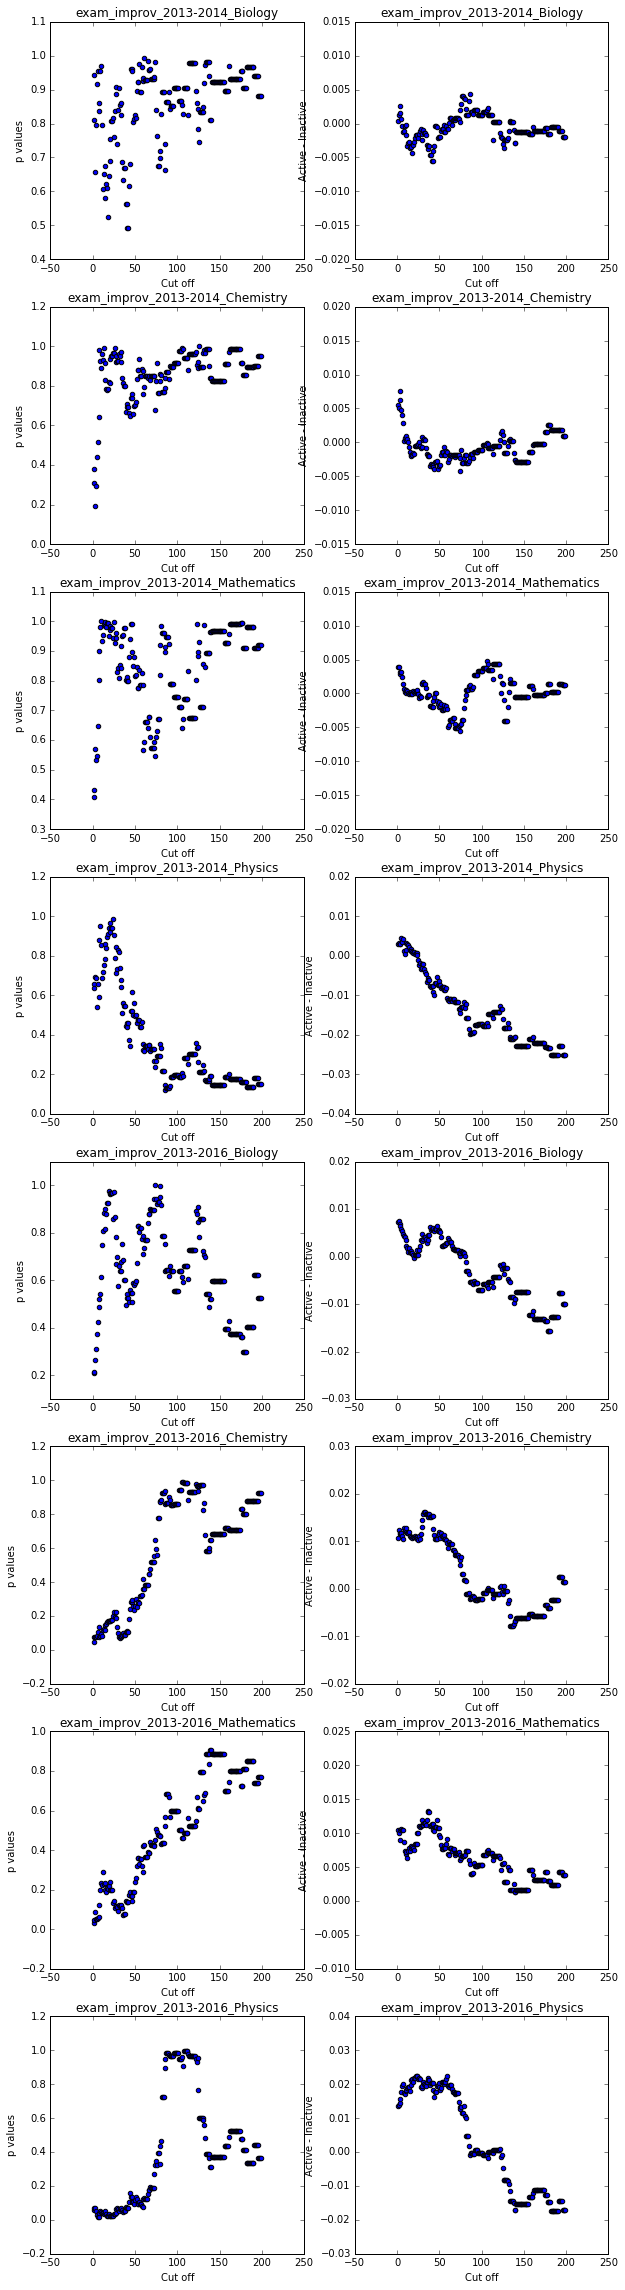

In [178]:

x_range = np.unique(df_score['Key'])
y_range = ['p values','Active - Inactive']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(df_test['Cut off'],df_test[item_y])
        #plt.plot(df_test['Cut off'], np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1


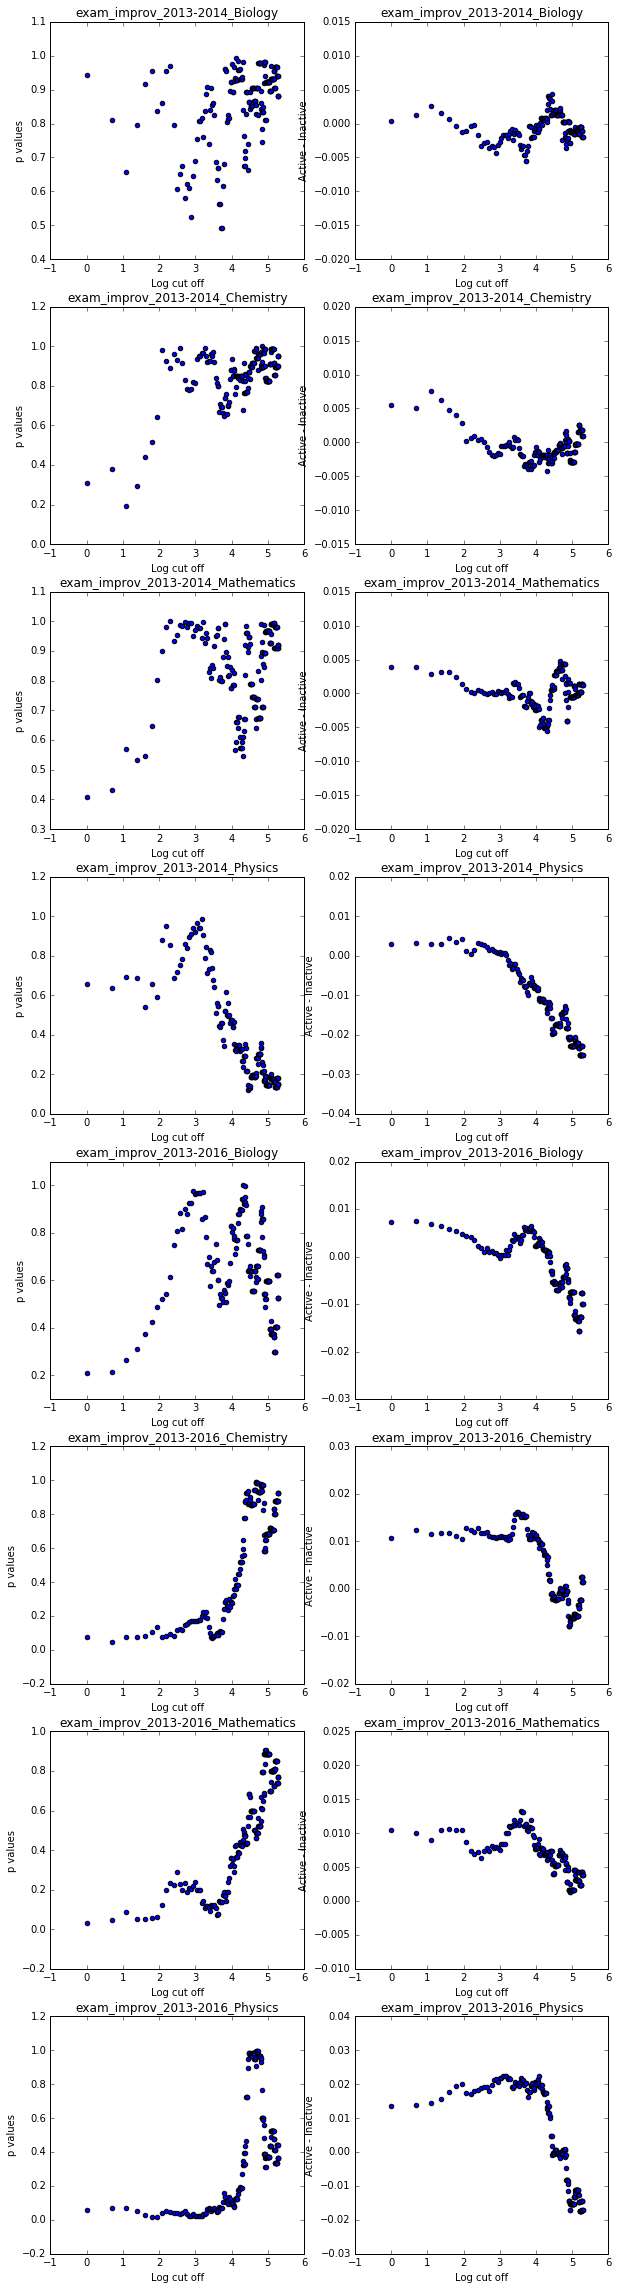

In [179]:
# Looking at exam results in Physics

x_range = np.unique(df_score['Key'])
y_range = ['p values','Active - Inactive']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(np.log(df_test['Cut off']),df_test[item_y])
        #plt.plot(np.log(df_test['Cut off']), np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Log cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1


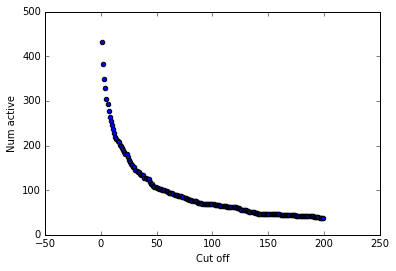

In [180]:
df_score.groupby('Cut off').min().reset_index().plot(kind='scatter',x='Cut off', y= 'Num active')

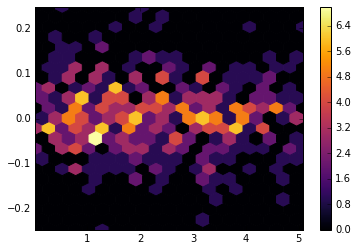

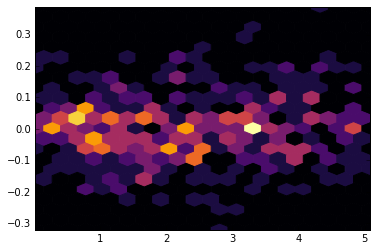

In [253]:
#df_out.plot(kind='hexbin',x='student_activity',y='exam_improv_2013-2016_Physics')

df_test = df_out[df_out['log_student_activity']>0]

plt.hexbin(df_test['log_student_activity'],df_test['exam_improv_2013-2016_Biology'],gridsize=20,cmap='inferno')
plt.colorbar()
#plt.plot(df_test['log_student_activity'],np.ones(df_test.shape[0])*df['exam_improv_2013-2016_Biology'].mean(),'-r')
plt.show()
plt.hexbin(df_test['log_student_activity'],df_test['exam_improv_2013-2016_Physics'],gridsize=20,cmap='inferno')
plt.show()

#plt.xlim([0,50])

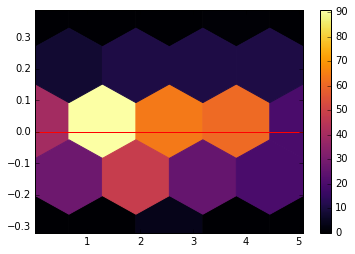

In [250]:
#df_out.plot(kind='hexbin',x='student_activity',y='exam_improv_2013-2016_Physics')

df_test = df_out[df_out['log_student_activity']>0]

plt.hexbin(df_test['log_student_activity'],df_test['exam_improv_2013-2016_Physics'],gridsize=4,cmap='inferno')
plt.colorbar()
plt.plot(df_test['log_student_activity'],np.ones(df_test.shape[0])*df['exam_improv_2013-2016_Biology'].mean(),'-r')

In [183]:
df_test[df_test['categories']=='Active'].filter(regex='exam_improv').mean() - df_test[df_test['categories']=='Inactive'].filter(regex='exam_improv').mean()[X.keys()]

exam_improv_2013-2014_Biology       NaN
exam_improv_2013-2014_Mathematics   NaN
exam_improv_2013-2014_Chemistry     NaN
exam_improv_2013-2014_Physics       NaN
exam_improv_2013-2016_Biology       NaN
exam_improv_2013-2016_Mathematics   NaN
exam_improv_2013-2016_Chemistry     NaN
exam_improv_2013-2016_Physics       NaN
dtype: float64

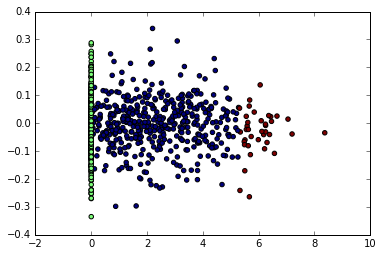

In [184]:
plt.scatter(df['log_student_activity'],df['exam_improv_2013-2014_Physics'],c=pd.factorize(df['categories'])[0])

,Coef,R^2,X,Y,intercept
0,-0.000118,0.000005,log_student_activity,exam_improv_2013-2014_Biology,0.005192
1,0.000286,0.000039,log_student_activity,exam_improv_2013-2014_Mathematics,0.005441
2,0.000739,0.000194,log_student_activity,exam_improv_2013-2014_Chemistry,0.001201
3,0.001533,0.000561,log_student_activity,exam_improv_2013-2014_Physics,-0.006578
4,0.001808,0.001044,log_student_activity,exam_improv_2013-2016_Biology,-0.001628
5,0.002310,0.002426,log_student_activity,exam_improv_2013-2016_Mathematics,-0.021192
6,0.003936,0.004609,log_student_activity,exam_improv_2013-2016_Chemistry,-0.013998
7,0.006519,0.008650,log_student_activity,exam_improv_2013-2016_Physics,-0.017426


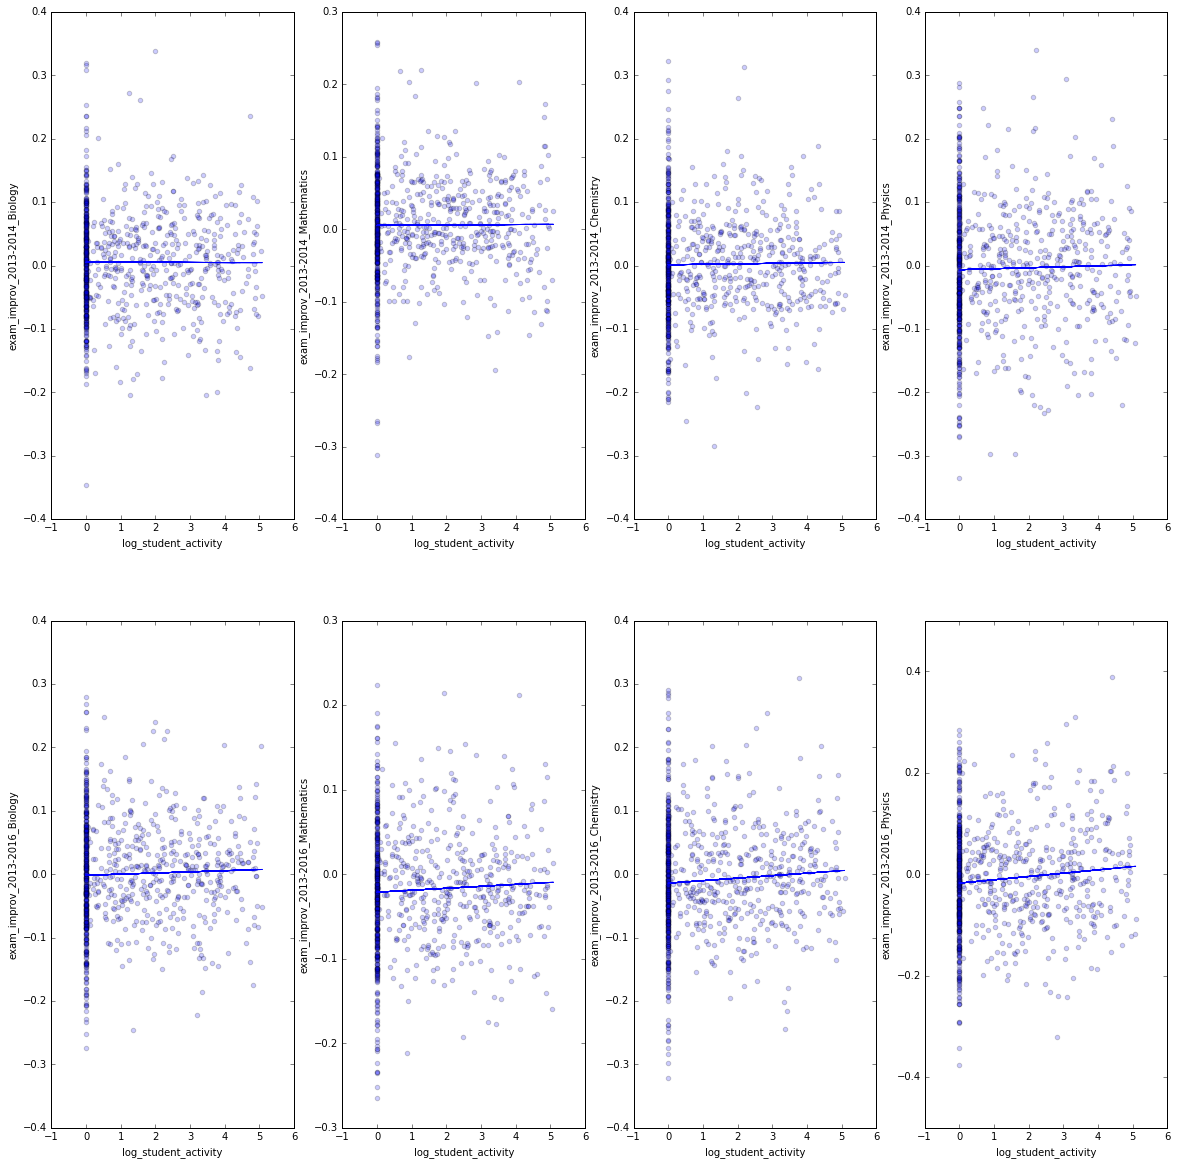

In [225]:
# Checking linear fit with no outliers

feature = ['log_student_activity']

df_test = df_out


df_score = checkLinearFit(df_test,feature,df_test.filter(like='exam').columns, n_cols=4, n_rows=2,figsize=(20,20))
df_score.sort_values(by='Coef')

In [245]:
 # Applying regression with mutual information
    
from sklearn.feature_selection import mutual_info_regression, f_regression

X = df_out.filter(regex='exam_improv')
y = df_out['log_student_activity']

mi = mutual_info_regression(X,y)
f_test, p_val = f_regression(X,y)

pd.DataFrame({'Key':X.keys(),'MI':mi,'f test':f_test, 'p values':p_val}).sort_values(by='f test',ascending=False)


,Key,MI,f test,p values
7,exam_improv_2013-2016_Physics,0.033339,7.433944,0.006532
6,exam_improv_2013-2016_Chemistry,0.016769,3.944763,0.047338
5,exam_improv_2013-2016_Mathematics,0.000606,2.071590,0.150432
4,exam_improv_2013-2016_Biology,0.036358,0.890318,0.345659
3,exam_improv_2013-2014_Physics,0.014337,0.478084,0.489480
2,exam_improv_2013-2014_Chemistry,0.003833,0.165192,0.684522
1,exam_improv_2013-2014_Mathematics,0.018708,0.032890,0.856131
0,exam_improv_2013-2014_Biology,0.000000,0.004371,0.947302


In [ ]:
from scipy import stats